In [1]:
import sys
import numpy as np
import os
import shutil
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from tqdm.notebook import tqdm  # progress bar (optional)
from deeptime.clustering import KMeans
import matplotlib.pyplot as plt
import argparse
from deeptime.plots import plot_markov_model
import matplotlib as mpl
import networkx as nx

In [2]:
def eucl_norm(data, cluster):
    return np.sqrt(np.sum((data-cluster)**2))

In [3]:
folder_xyz="folder_trajectories"
list_enc=[2, 16, 77, 81, 90, 95, 97, 125, 138, 143, 154, 158, 160, 166, 176, 204, 210, 213, 217, 219, 226, 231, 236, 247, 250, 252, 256, 265, 278, 301, 302, 313, 355, 369, 379, 383, 388, 402, 408, 414, 428, 431, 433, 490, 494]
folder_msm="folder_MSM_LAGTIME"
num_clus=6
lagtime_msm=1
seed_kmeans=1
max_iter_kmeans=5000
allow_disconnected_input=False
reversible_input=False


print()
print(f"Running KMeans with n_clusters = {num_clus}")
print(f"Running MSM with allow_disconnected = {allow_disconnected_input}")
print(f"Running MSM with reversibility = {reversible_input}")

data=[]
for num in list_enc:
    for file in os.listdir("./"+folder_xyz+"_"+str(num)+"_xyz"):
    #if "trajectories_1" in file:
        data.append(np.loadtxt("./"+folder_xyz+"_"+str(num)+"_xyz/"+file))

estimator = KMeans(
    n_clusters=num_clus,  # place 100 cluster centers
    init_strategy='uniform',  # kmeans++ initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=seed_kmeans
)

clustering = estimator.fit(np.concatenate(data)).fetch_model()
assignments = clustering.transform(np.concatenate(data))
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = max_iter_kmeans
clustering_new = estimator.fit(np.concatenate(data)).fetch_model()

dtrajs = [estimator.transform(t) for t in data]


msm = MaximumLikelihoodMSM(lagtime=lagtime_msm, reversible=reversible_input, allow_disconnected=allow_disconnected_input).fit_fetch(dtrajs)



Running KMeans with n_clusters = 6
Running MSM with allow_disconnected = False
Running MSM with reversibility = False



Running KMeans with n_clusters = 6
Running MSM with allow_disconnected = False
Running MSM with reversibility = False


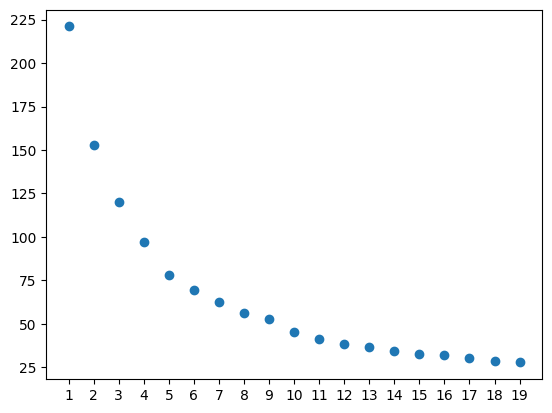

In [4]:
folder_xyz="folder_trajectories"
list_enc=[2, 16, 77, 81, 90, 95, 97, 125, 138, 143, 154, 158, 160, 166, 176, 204, 210, 213, 217, 219, 226, 231, 236, 247, 250, 252, 256, 265, 278, 301, 302, 313, 355, 369, 379, 383, 388, 402, 408, 414, 428, 431, 433, 490, 494]
folder_msm="folder_MSM_LAGTIME"
num_clus=6
lagtime_msm=1
seed_kmeans=1
max_iter_kmeans=5000
allow_disconnected_input=False
reversible_input=False


print()
print(f"Running KMeans with n_clusters = {num_clus}")
print(f"Running MSM with allow_disconnected = {allow_disconnected_input}")
print(f"Running MSM with reversibility = {reversible_input}")

data=[]
for num in list_enc:
    for file in os.listdir("./"+folder_xyz+"_"+str(num)+"_xyz"):
    #if "trajectories_1" in file:
        data.append(np.loadtxt("./"+folder_xyz+"_"+str(num)+"_xyz/"+file))

#num_clusters=np.array([3,4,5,6,7,8,9,10])
num_clusters=np.arange(1,20,1)
wcss_values=[]
wcss_values_std=[]
for numi_clus in num_clusters:
    estimator = KMeans(
        n_clusters=numi_clus,  # place 100 cluster centers
        init_strategy='uniform',  # kmeans++ initialization strategy
        max_iter=0,  # don't actually perform the optimization, just place centers
        fixed_seed=seed_kmeans
    )
    
    clustering = estimator.fit(np.concatenate(data)).fetch_model()
    assignments = clustering.transform(np.concatenate(data))
    estimator.initial_centers = clustering.cluster_centers
    estimator.max_iter = max_iter_kmeans
    clustering_new = estimator.fit(np.concatenate(data)).fetch_model()

    dtrajs = [estimator.transform(t) for t in data]
    
    wcss=0
    tot_frame=0
    for d,dtraj in enumerate(dtrajs):
        for t,frame in enumerate(dtraj):
            wcss+=eucl_norm(data[d][t], clustering_new.cluster_centers[dtrajs[d][t]])**2
            tot_frame+=1
    wcss=wcss/tot_frame

    wcss_std=0
    for d,dtraj in enumerate(dtrajs):
        for t,frame in enumerate(dtraj):
            wcss_std+=(eucl_norm(data[d][t], clustering_new.cluster_centers[dtrajs[d][t]])**2-wcss)**2
    wcss_std=np.sqrt(wcss_std/tot_frame)

    
    wcss_values.append(wcss)
    wcss_values_std.append(wcss_std)

plt.scatter(num_clusters,wcss_values)
#plt.errorbar(num_clusters,wcss_values,yerr=wcss_values_std)
plt.xticks(num_clusters)
plt.show()

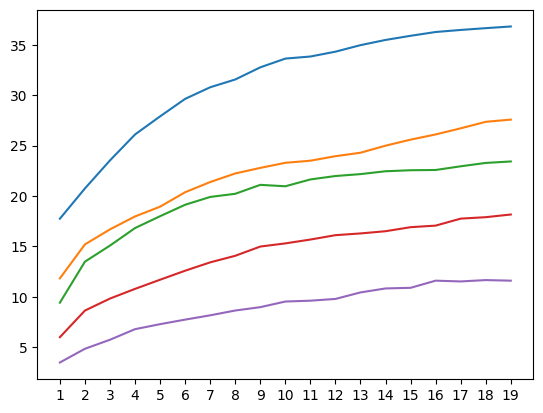

In [5]:
num_clus=6

estimator = KMeans(
        n_clusters=num_clus,  # place 100 cluster centers
        init_strategy='uniform',  # kmeans++ initialization strategy
        max_iter=0,  # don't actually perform the optimization, just place centers
        fixed_seed=seed_kmeans
)
    
clustering = estimator.fit(np.concatenate(data)).fetch_model()
assignments = clustering.transform(np.concatenate(data))
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = max_iter_kmeans
clustering_new = estimator.fit(np.concatenate(data)).fetch_model()

dtrajs = [estimator.transform(t) for t in data]



lagtimes=np.array([1,2,3,4,5,6,7,8,9])
lagtimes=np.arange(1,20,1)

eigenv_relax=np.zeros((num_clus-1,len(lagtimes)))
for i,lag in enumerate(lagtimes):
    counts = TransitionCountEstimator(lagtime=lag, count_mode="effective").fit(dtrajs).fetch_model()
    msm = BayesianMSM().fit(counts).fetch_model()
    #msm = BayesianMSM(lagtime=lag, reversible=reversible_input).fit_fetch(dtrajs)
    try:
        for eiv in range(num_clus-1):
            eigenv_relax[eiv,i]=msm.prior.timescales()[eiv]
    except:
        pass
for eiv in range(num_clus-1):
    plt.plot(eigenv_relax[eiv])
plt.xticks(ticks=lagtimes-1, labels=lagtimes)
plt.show()

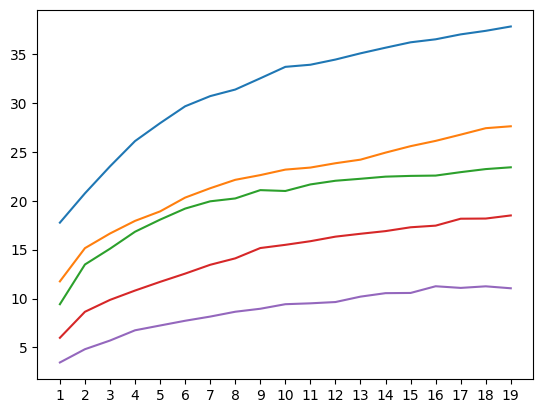

In [6]:
num_clus=6

estimator = KMeans(
        n_clusters=num_clus,  # place 100 cluster centers
        init_strategy='uniform',  # kmeans++ initialization strategy
        max_iter=0,  # don't actually perform the optimization, just place centers
        fixed_seed=seed_kmeans
)
    
clustering = estimator.fit(np.concatenate(data)).fetch_model()
assignments = clustering.transform(np.concatenate(data))
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = max_iter_kmeans
clustering_new = estimator.fit(np.concatenate(data)).fetch_model()

dtrajs = [estimator.transform(t) for t in data]

lagtimes=np.array([1,2,3,4,5,6,7,8,9])
lagtimes=np.arange(1,20,1)

eigenv_relax=np.zeros((num_clus-1,len(lagtimes)))
for i,lag in enumerate(lagtimes):
    msm = MaximumLikelihoodMSM(lagtime=lag, reversible=reversible_input, allow_disconnected=allow_disconnected_input).fit_fetch(dtrajs)
    for eiv in range(num_clus-1):
        eigenv_relax[eiv,i]=msm.timescales()[eiv]
for eiv in range(num_clus-1):
    plt.plot(eigenv_relax[eiv])
plt.xticks(ticks=lagtimes-1, labels=lagtimes)
plt.show()